In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.decomposition import IncrementalPCA
from sklearn.datasets import make_swiss_roll
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import mean_squared_error
from sklearn.manifold import LocallyLinearEmbedding

In [2]:
# create dataset

np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)


In [3]:
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [4]:
# This tells you that 84.2% of the dataset’s variance lies along the first axis, 
# and 14.6% lies along the second axis.
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

In [5]:
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

2

In [6]:
# get mnist data

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)                                   

In [7]:
# selecting dimension to explain 95% of variance
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

154

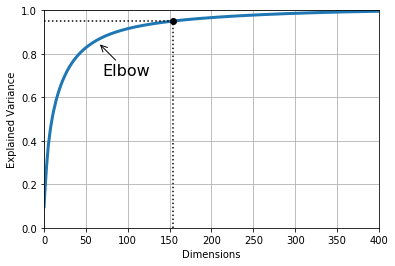

In [8]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])

plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")

## '^k:' black triangle_up markers connected by a dotted line

# plot vertical line
plt.plot([d, d], [0, 0.95], "k:")

# plot horizontal line
plt.plot([0, d], [0.95, 0.95], "k:")

# plot circular mark
plt.plot(d, 0.95, "ko")

# plot label on graph
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),arrowprops=dict(arrowstyle="->"), fontsize=16)

plt.grid(True)
plt.show()

In [9]:
# instead of specifying the number of principal components we want to preserve
# we can set n_components to be a float between 0.0 and 1.0
# indicating the ratio of variance you wish to preserve
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [10]:
pca.n_components_

154

In [11]:
# reconstruction error
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [12]:
# randomized pca
rnd_pca = PCA(n_components=154, svd_solver="randomized")
X_reduced = rnd_pca.fit_transform(X_train)

In [13]:
# incremental PCA
n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)
X_reduced = inc_pca.transform(X_train)

In [17]:
X.shape

(70000, 784)

In [22]:
# create data
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [23]:
# kernel PCA
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

In [33]:
# create classification dataset
X,y = make_classification(n_samples=10000,n_features=5,)

In [36]:
## finetunning kernel pca hyperparamter
clf = Pipeline([("kpca", KernelPCA(n_components=2)),("log_reg", LogisticRegression())])

# Parameters of pipelines can be set using ‘__’ separated paramet
# https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html
param_grid = [{"kpca__gamma": np.linspace(0.03, 0.05, 10),"kpca__kernel": ["rbf", "sigmoid"]}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('kpca',
                                        KernelPCA(alpha=1.0, coef0=1,
                                                  copy_X=True, degree=3,
                                                  eigen_solver='auto',
                                                  fit_inverse_transform=False,
                                                  gamma=None, kernel='linear',
                                                  kernel_params=None,
                                                  max_iter=None, n_components=2,
                                                  n_jobs=None,
                                                  random_state=None,
                                                  remove_zero_eig=False,
                                                  tol=0)),
                                       ('log_reg',
                                 

In [37]:
# best hyperparameters
 print(grid_search.best_params_)

{'kpca__gamma': 0.04777777777777778, 'kpca__kernel': 'sigmoid'}


In [38]:
## inverse transfrom kernel pca
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [40]:
# reconstruction error
mean_squared_error(X, X_preimage)

0.21422629045837036

In [42]:
## Local Linear Embedding - Non Linear 
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced = lle.fit_transform(X)